In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, roc_auc_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import median_abs_deviation

In [2]:
def preprocess(df, humanCheck = False):
    listIntToBool = ['AU7', 'AU20', 'looking_away']
    for col in listIntToBool:
        df[col] = df[col].astype('bool')
        
    listBB = ['FaceRectX', 'FaceRectY', 'FaceRectWidth', 'FaceRectHeight']
    listLandmarks = ['x' + str(i) for i in range(68)] + ['y' + str(i) for i in range(68)]
    listTime = ['Timestamp']
    
    listAUDiff = ['AU1_diff','AU2_diff','AU4_diff','AU5_diff','AU6_diff','AU7_diff','AU9_diff','AU10_diff','AU11_diff','AU12_diff',
                'AU14_diff','AU15_diff','AU17_diff','AU20_diff','AU23_diff','AU24_diff','AU25_diff','AU26_diff','AU28_diff','AU43_diff']
    listEmoDiff = ['disgust_diff','fear_diff','happiness_diff', 'anger_diff', 'sadness_diff','surprise_diff','neutral_diff','emotion_mirroring_diff']
    
    listEyes = ['eyeWidth', 'eyeHeight', 'mean_EAR', 'mean_pupil_ratio']
    
    listAU = ['AU1','AU2','AU4','AU5','AU6','AU7','AU9','AU10','AU11',
              'AU12','AU14','AU15','AU17','AU20','AU23','AU24','AU25','AU26','AU28','AU43']
    
    listFaceDirection = ['Pitch', 'Yaw', 'Roll']
    
    featureTest = ['AU5', 'AU10', 'AU15', 'AU26', 'AU28', 'looking_away', 'AU1_diff', 'AU2_diff', 'AU4_diff', 'AU5_diff', 'AU6_diff', 'AU7_diff', 'AU9_diff', 'AU10_diff', 
                   'AU11_diff', 'AU12_diff', 'AU14_diff', 'AU15_diff', 'AU17_diff', 'AU20_diff', 'AU23_diff', 'AU24_diff', 'AU25_diff', 'AU26_diff', 'AU28_diff', 
                   'AU43_diff', 'anger_diff', 'disgust_diff', 'fear_diff', 'happiness_diff', 'surprise_diff', 'neutral_diff']
    ##      + listEmoDiff 
    listOther = ['emotion_mirroring_diff']
    
    totalcolumns = listBB + listLandmarks + listTime  + listEyes + featureTest + listOther# + listFaceDirection
        
    df = df.drop(columns = totalcolumns)
    df = df.drop(columns=['pupil_direction', 'Person'])
    df = df[df['Label'] != 'x']
    df = df[df['Label'] != 'skip']
    df['Label'] = df['Label'].replace({'n': 0, 'no': 0, 'y': 1, 'yes': 1})
    if humanCheck:
        df['liridonLabels'] = df['liridonLabels'].replace({'n': 0, 'no': 0, 'y': 1, 'yes': 1})
        df['elenaLabels'] = df['elenaLabels'].replace({'n': 0, 'no': 0, 'y': 1, 'yes': 1})
        df['sunnyLabels'] = df['sunnyLabels'].replace({'n': 0, 'no': 0, 'y': 1, 'yes': 1})
    return df


## TODO: 
############################ INSTEAD OF MEAN, DO AGGREGATION FOR VALUES CONTAINING 'DIFF'!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
########################################################################################################################################
############ 23 juni ######################################################################
def generate_chunk_summary(chunk, global_statistics={}, fullList=[], meanSDList=[], humanCheck = False):
    chunk_df = pd.DataFrame(chunk)
    chunk_summary = chunk_df.mean().to_dict()  # calculate mean for all columns\n",
    for col in fullList:  # calculate quartiles and standard deviation for columns in fullList\n",
        chunk_summary.update({
            f'{col}_mean': chunk_df[col].mean(),
            f'{col}_Q1': chunk_df[col].quantile(0.25),
            f'{col}_Q2': chunk_df[col].median(),
            f'{col}_Q3': chunk_df[col].quantile(0.75),
            f'{col}_SD': chunk_df[col].std(),
            f'{col}_MAD': median_abs_deviation(chunk_df[col])
        })
    for col in meanSDList:  # calculate quartiles and standard deviation for columns in fullList\n",
        chunk_summary.update({
            f'{col}_mean': chunk_df[col].mean(),
            f'{col}_SD': chunk_df[col].std(),
        })    
    chunk_summary['Label'] = chunk_df['Label'].values[-1]
    if humanCheck:
        chunk_summary['liridonLabels'] = chunk_df['liridonLabels'].values[-1]
        chunk_summary['elenaLabels'] = chunk_df['elenaLabels'].values[-1]
        chunk_summary['sunnyLabels'] = chunk_df['sunnyLabels'].values[-1]
    return chunk_summary


def create_chunks(df, chunk_size, global_statistics={}, humanCheck = False):
    fullList = ['EAR']
    fewList = [] # 'Pitch', 'Yaw', 'Roll'
    df_new = pd.DataFrame()
    current_chunk = []
    start_of_probe = -1
    summaries = []

    for _, row in df.iterrows():
        if start_of_probe < 0 or (row['Frame'] - start_of_probe) >= 500:
            # Finalize the current chunk, if there is one
            if current_chunk:
                chunk_summary = generate_chunk_summary(current_chunk, global_statistics, fullList, fewList, humanCheck)
                summaries.append(chunk_summary)
            
            # Start a new probe and a new chunk
            start_of_probe = row['Frame']
            current_chunk = [row]
        elif len(current_chunk) == chunk_size:
            # We have a complete chunk, so finalize it
            chunk_summary = generate_chunk_summary(current_chunk, global_statistics, fullList, fewList, humanCheck)
            summaries.append(chunk_summary)
            current_chunk = [row]
        else:
            # Add the current row to the current chunk
            current_chunk.append(row)

    # Finalize the last chunk, if there is one
    if current_chunk:
        chunk_summary = generate_chunk_summary(current_chunk, global_statistics, fullList, fewList, humanCheck)
        summaries.append(chunk_summary)
    
    df_new = pd.DataFrame(summaries)
    return df_new

def preprocess_and_chunk(filename, chunk_size, cols_full=[], humanCheck = False):
    df = pd.read_csv(filename)
    
    columns_of_interest = [] # Add more columns if needed
    global_statistics = {
        'mean': {col: df[col].mean() for col in columns_of_interest},
        'sd': {col: df[col].std() for col in columns_of_interest},
        'mad': {col: df[col].mad() for col in columns_of_interest},
        'quartiles': {col: df[col].quantile([0.25, 0.5, 0.75]).to_dict() for col in columns_of_interest}
    }    
    cols_full = ['happiness']
    for col in cols_full:
        mean_full = df[col].mean()
        df[f'{col}_mean_full'] = mean_full
        df[f'{col}_mean_diff'] = df[col] - mean_full
    
    df['head_movement'] = df[['Pitch', 'Yaw', 'Roll']].diff().abs().sum(axis=1)
    df['Yaw_normalized'] = (df['Yaw'] + 90) / 180
    df['combined_gaze'] = (df['Yaw_normalized'] + df['pupil_ratio']) / 2
    df = df.drop(columns='Yaw_normalized')
    mean_value = df['EAR'].iloc[:1000].mean()
    df['calibrated_EAR'] = mean_value
    combined_gaze = df['combined_gaze'].iloc[:1000].mean()
    df['calibrated_combined_gaze'] = combined_gaze
    df['gaze_deviation_from_start'] = abs(df['combined_gaze'] - df['calibrated_combined_gaze'])
    #df['pupil_deviation'] = abs(df['mean_pupil_ratio'] - df['pupil_ratio'])
    df['EAR_deviation'] = abs(df['EAR'] - df['calibrated_EAR'])
    
    drop_columns = [f'{col}_mean_full' for col in cols_full]
    df = df.drop(columns=drop_columns)
    
    df = preprocess(df, humanCheck)

    df_chunks = create_chunks(df, chunk_size, global_statistics, humanCheck)
    df_chunks = df_chunks.drop(columns=['calibrated_EAR', 'calibrated_combined_gaze', 'EAR'])
      
    return df_chunks

def checkForFullYes(filename):
    df = pd.read_csv(filename)
    counts = df['Label'].value_counts()
    no_count = counts.get('no', 0)
    n_count = counts.get('n', 0)
    finalcount = no_count + n_count
    #print(filename, finalcount)
    return finalcount

In [3]:
kalman = False
if kalman == True:
    kalman = '_kalman'
else: kalman = ''
print(kalman)
number = 250
filenames = [f"finaldata_{number}{kalman}/{i}.csv" for i in range(1, 39)]  ## ["1.csv", "2.csv", ..., "38.csv"]

test_indices = [5, 8, 15, 17, 23, 32, 37]  ## generate test set based on index name

train_filenames = [f for i, f in enumerate(filenames, start=1) if i not in test_indices]
test_filenames = [f for i, f in enumerate(filenames, start=1) if i in test_indices]

dataframes_train = []
dataframes_test = []

chunkBool = 1
chunk_size = 25  


if chunkBool:
    for filename in train_filenames:
        finalcount = checkForFullYes(filename)
        if finalcount == 0:
            continue      
        chunked_df = preprocess_and_chunk(filename, chunk_size)
        dataframes_train.append(chunked_df)
    
    for filename in test_filenames:
        finalcount = checkForFullYes(filename)
        if finalcount == 0:
            continue          
        chunked_df = preprocess_and_chunk(filename, chunk_size)
        dataframes_test.append(chunked_df)
else:
    for filename in train_filenames:
        df = pd.read_csv(filename)
        preprocessed_df = preprocess(df)
        dataframes_train.append(preprocessed_df)

    for filename in test_filenames:
        df = pd.read_csv(filename)
        preprocessed_df = preprocess(df)
        dataframes_test.append(preprocessed_df)
    

train_combined_df = pd.concat(dataframes_train, ignore_index=True)
X_train = train_combined_df.drop(columns=['Label', 'Frame'])
y_train = train_combined_df['Label']

test_combined_df = pd.concat(dataframes_test, ignore_index=True)
X_test = test_combined_df.drop(columns=['Label', 'Frame'])
y_test = test_combined_df['Label']

In [4]:
y_test.value_counts()


# 1.00    1516
# 0.00     240

1    1096
0     207
Name: Label, dtype: int64

In [5]:
smote = SMOTE(random_state=42)


In [6]:
print(len(y_train))
print(y_train.value_counts())
## 5270, 1288

3464
1    2806
0     658
Name: Label, dtype: int64


In [7]:
X_train_filled = X_train.fillna(X_train.median())
X_test_filled = X_test.fillna(X_train.median())

In [8]:
from imblearn.under_sampling import NearMiss
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer, f1_score

# Create a custom scorer
def negative_class_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, pos_label=0)  # Assuming 0 is the label for the negative class

negative_class_f1_scorer = make_scorer(negative_class_f1)


smoteBool = 0
undersampleBool = 0

#rfecv = RFECV(estimator=XGBClassifier(), step=1, cv=StratifiedKFold(5), scoring=negative_class_f1_scorer)

if smoteBool:
    print('SMOTE xgboost')
    X_train_smote, y_train_smote = smote.fit_resample(X_train_filled, y_train)
    scale_pos_weight = len(y_train_smote[y_train_smote == 0]) / len(y_train_smote[y_train_smote == 1])
    model = XGBClassifier(objective='binary:logistic', random_state=42, scale_pos_weight=(scale_pos_weight), 
                              learning_rate=0.12, min_child_weight=1, max_delta_step=5,
                              n_estimators = 200)
    model.fit(X_train_smote, y_train_smote)
elif undersampleBool:
    print('UNDERSAMPLE xgboost')
    nm = NearMiss()
    X_train_filled, y_train = nm.fit_resample(X_train_filled, y_train)
    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    model = make_pipeline(rfecv, XGBClassifier(objective='binary:logistic', random_state=42, scale_pos_weight=scale_pos_weight))  # Adjust hyperparameters as needed
    model.fit(X_train_filled, y_train)
else:
    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    print(f'REGULAR xgboost, scale_weight:{scale_pos_weight}')
    
    # model = make_pipeline(rfecv, XGBClassifier(objective='binary:logistic', random_state=42, scale_pos_weight=(scale_pos_weight/3), 
    #                           learning_rate=0.12, min_child_weight=1, max_delta_step=5,
    #                           n_estimators = 200))  # Adjust hyperparameters as needed
    model = XGBClassifier(objective='binary:logistic', random_state=42, scale_pos_weight=(scale_pos_weight/3), 
                              learning_rate=0.12, min_child_weight=1, max_delta_step=5,
                              n_estimators = 200)
    model.fit(X_train_filled, y_train)


REGULAR xgboost, scale_weight:0.2344975053456878


In [9]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Standardize the features
scaler = StandardScaler()
# Create a pipeline: standardize, then run SVM
svm_clf = make_pipeline(scaler, svm.SVC(kernel='rbf' ,class_weight='balanced', random_state=42, probability=1, gamma='auto', C=1))

# Fit the SVM model
if smoteBool:
    svm_clf.fit(X_train_smote, y_train_smote)
    y_pred_svm = svm_clf.predict(X_test_filled)
else:
    svm_clf.fit(X_train_filled, y_train)
    y_pred_svm = svm_clf.predict(X_test_filled)

In [10]:
# import lime
# from lime import lime_tabular
# import re

# feature_names = X_test_filled.columns.tolist()

# # Initialize a dictionary to hold the sum of each feature's weight
# feature_weights = dict(zip(feature_names, [0]*len(feature_names)))

# # Iterate over each instance in the test set
# for i in range(20): ##X_test_filled.values.shape[0]
#     # Generate explanation for the instance
#     exp = explainer.explain_instance(X_test_filled.values[i], svm_clf.predict_proba, num_features=len(feature_names))
    
#     # Update the feature weights based on the explanation
#     for feature_and_condition, weight in exp.as_list():
#         # Split on "<=" or ">" to get the actual feature name
#         possible_features = re.split("<=|>|<|=", feature_and_condition)
#         # Remove extra whitespace and check if it is in feature_names
#         feature = [feat.strip() for feat in possible_features if feat.strip() in feature_names]
        
#         if len(feature) > 0:
#             print(f"Updating weight for feature {feature[0]} with {weight}")  # Debug print
#             feature_weights[feature[0]] += weight
#         else:
#             print(f"Unexpected feature or condition: {feature_and_condition}")  # Debug print

# # Calculate the average weight for each feature
# feature_weights_avg = {feature: weight / X_test_filled.values.shape[0] for feature, weight in feature_weights.items()}

# # Print the features and their average weights, rounded to 2 decimal places
# for feature, avg_weight in feature_weights_avg.items():
#     print(f"{feature}: {round(avg_weight, 2)}")

In [11]:
print(len(X_train_filled))

y_pred = model.predict(X_test_filled)
y_pred_proba_xgb = model.predict(X_test_filled)
y_no_emo_xgb = y_pred
print('--------- XGB ------------')
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

print('------------SVM-------------')
accuracy = accuracy_score(y_test, y_pred_svm)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_test, y_pred_svm))

y_pred_svm = svm_clf.predict(X_test_filled)
y_no_emo_svm = y_pred_svm


cm = confusion_matrix(y_test, y_pred_svm)
print("Confusion Matrix:")
print(cm)

aurocXGB = roc_auc_score(y_test, y_pred)
print(f'aurocXGB:{aurocXGB}')
print('------------XGB-PROBA--------------')
y_pred_proba = model.predict_proba(X_test_filled)[:,1]


## 41, 63, 50 -- 92, 83, 87 -- 84, 80 , 82
## 40, 62, 48 -- 92, 82, 87 -- 84, 79 , 81



3464
--------- XGB ------------
Accuracy: 78.89%
              precision    recall  f1-score   support

           0       0.36      0.43      0.40       207
           1       0.89      0.86      0.87      1096

    accuracy                           0.79      1303
   macro avg       0.63      0.65      0.63      1303
weighted avg       0.81      0.79      0.80      1303

Confusion Matrix:
[[ 90 117]
 [158 938]]
------------SVM-------------
Accuracy: 79.97%
              precision    recall  f1-score   support

           0       0.41      0.63      0.50       207
           1       0.92      0.83      0.87      1096

    accuracy                           0.80      1303
   macro avg       0.67      0.73      0.69      1303
weighted avg       0.84      0.80      0.82      1303

Confusion Matrix:
[[131  76]
 [185 911]]
aurocXGB:0.6453110123770232
------------XGB-PROBA--------------


0.7543284318911105
0.7601356712154872


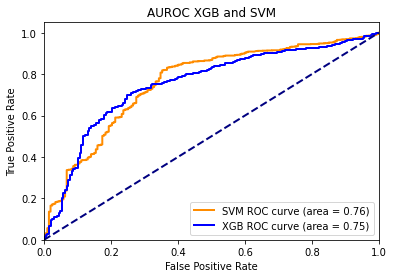

In [12]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
y_score_svm = svm_clf.predict_proba(X_test_filled)[:, 1] 

# Compute probabilities for XGB
y_score_xgb = model.predict_proba(X_test_filled)[:, 1]

# Compute ROC curve and ROC area for SVM
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_score_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Compute ROC curve and ROC area for XGB
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_score_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
print(roc_auc_xgb) ## 75 met emo
print(roc_auc_svm) ## 76 met emo

# Generate plot
plt.figure()
lw = 2  # line width
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=lw, label='SVM ROC curve (area = %0.2f)' % roc_auc_svm)
plt.plot(fpr_xgb, tpr_xgb, color='blue', lw=lw, label='XGB ROC curve (area = %0.2f)' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')  # diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUROC XGB and SVM')
plt.legend(loc="lower right")
plt.show()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


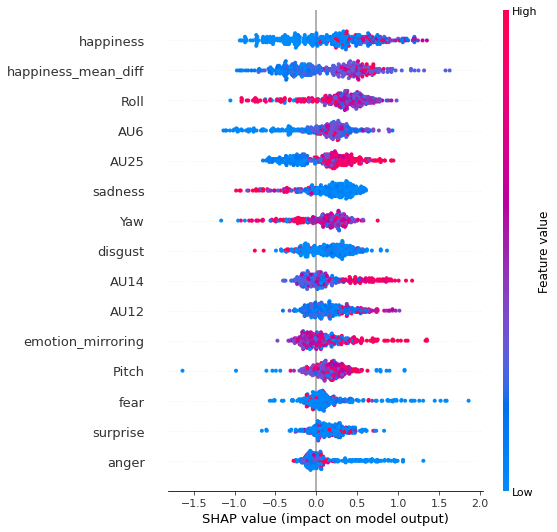

In [13]:
import shap

# Create object that can calculate shap values
explainer = shap.TreeExplainer(model)

# Define the number of samples you want
num_samples = 350

# Calculate Shap values
if smoteBool:
    print('smote')
    sample = X_train_smote.sample(n=num_samples, random_state=42, replace=True)
    shap_values = explainer.shap_values(sample)
    shap.summary_plot(shap_values, sample)
else:
    sample = X_train_filled.sample(n=num_samples, random_state=42, replace=True)
    shap_values = explainer.shap_values(sample)
    shap.summary_plot(shap_values, sample, max_display=15)


In [14]:
# from lazypredict.Supervised import LazyClassifier
# from sklearn.model_selection import train_test_split
# import pandas as pd

# X_train_smote, y_train_smote = smote.fit_resample(X_train_filled, y_train)

# clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
# models,predictions = clf.fit(X_train_smote, X_test_filled, y_train_smote, y_test)

# # Prints the model performance
# print(models)

In [15]:
# ###Create a background dataset (you can also use a subset of your train dataset)
# background_data = X_train_filled.iloc[90:93,:]

# ###Use KernelExplainer for SVM
# explainer = shap.KernelExplainer(svm_clf.predict_proba, background_data)

# ###Calculate shap_values for all of X
# shap_values = explainer.shap_values(X_test_filled)

# ###Plot the SHAP values
# shap.summary_plot(shap_values, X_test_filled)


Accuracy: 79.97%
              precision    recall  f1-score   support

           0       0.41      0.63      0.50       207
           1       0.92      0.83      0.87      1096

    accuracy                           0.80      1303
   macro avg       0.67      0.73      0.69      1303
weighted avg       0.84      0.80      0.82      1303



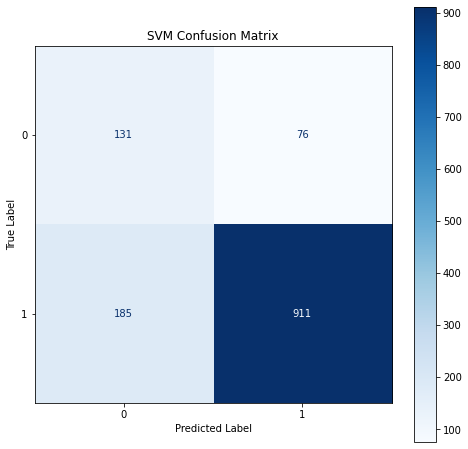

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_svm)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_test, y_pred_svm))

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)

y_pred_without_emo = y_pred_svm

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
# control font size by specifying a format string for the numbers
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='.0f')

plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [17]:
import numpy as np
def smooth_data(data, window_size, method='average'):
    if method == 'average':
        window = np.ones(window_size) / window_size
        smoothed_data = np.convolve(data, window, mode='same')
    elif method == 'gaussian':
        window = np.hanning(window_size)
        window /= window.sum()
        smoothed_data = np.convolve(data, window, mode='same')
    else:
        raise ValueError(f"Unknown method: {method}")
    return smoothed_data



5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.86      0.98      0.92       136

    accuracy                           0.85       157
   macro avg       0.43      0.49      0.46       157
weighted avg       0.75      0.85      0.79       157



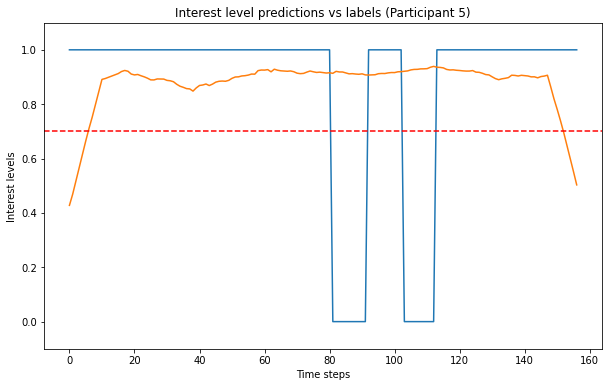

8
              precision    recall  f1-score   support

           0       0.33      0.09      0.14        22
           1       0.88      0.97      0.92       151

    accuracy                           0.86       173
   macro avg       0.61      0.53      0.53       173
weighted avg       0.81      0.86      0.83       173



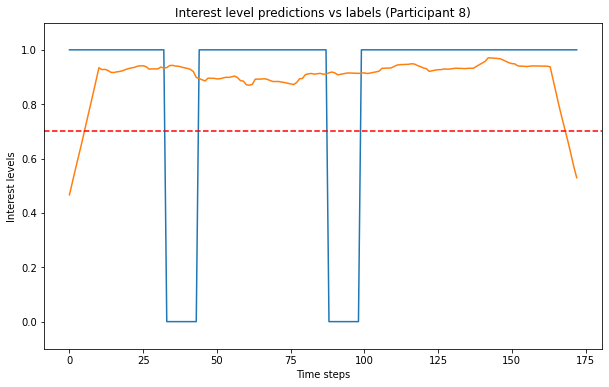

15
              precision    recall  f1-score   support

           0       0.61      0.86      0.72        44
           1       0.97      0.88      0.92       194

    accuracy                           0.87       238
   macro avg       0.79      0.87      0.82       238
weighted avg       0.90      0.87      0.88       238



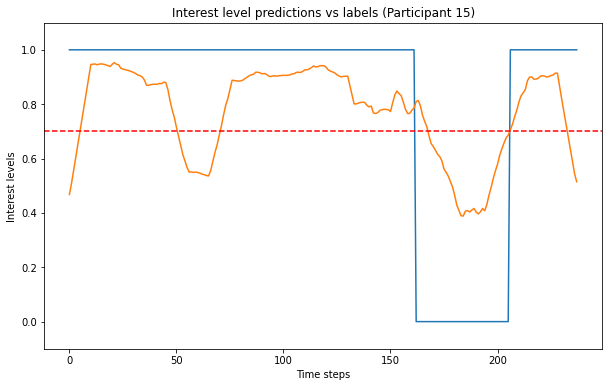

17
              precision    recall  f1-score   support

           0       0.42      0.85      0.57        33
           1       0.95      0.71      0.81       132

    accuracy                           0.74       165
   macro avg       0.69      0.78      0.69       165
weighted avg       0.84      0.74      0.76       165



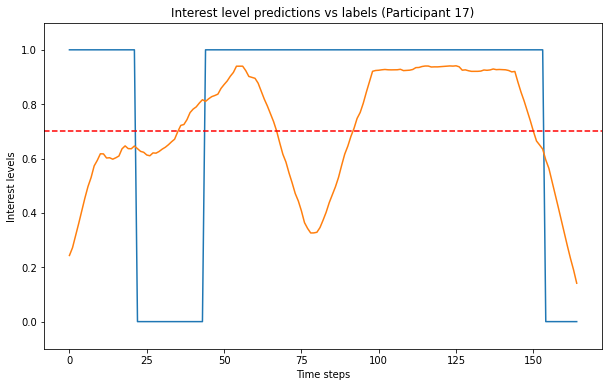

23
              precision    recall  f1-score   support

           0       0.34      0.77      0.47        22
           1       0.97      0.82      0.89       182

    accuracy                           0.81       204
   macro avg       0.65      0.80      0.68       204
weighted avg       0.90      0.81      0.84       204



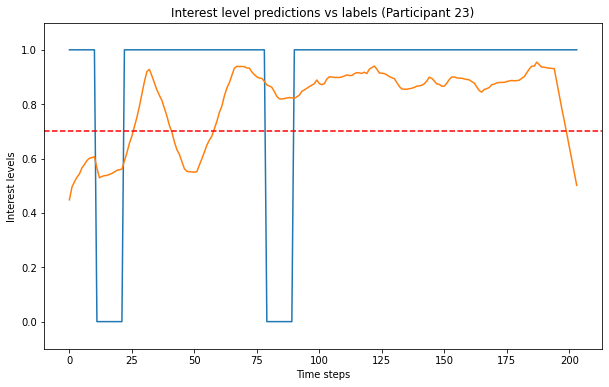

32
              precision    recall  f1-score   support

           0       0.36      0.52      0.43        23
           1       0.93      0.88      0.91       175

    accuracy                           0.84       198
   macro avg       0.65      0.70      0.67       198
weighted avg       0.87      0.84      0.85       198



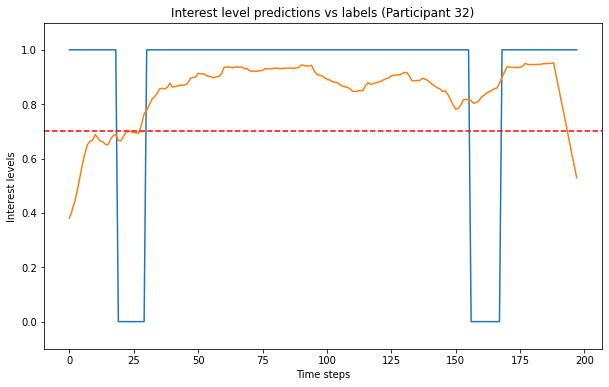

37
              precision    recall  f1-score   support

           0       0.35      0.81      0.49        42
           1       0.89      0.51      0.65       126

    accuracy                           0.58       168
   macro avg       0.62      0.66      0.57       168
weighted avg       0.76      0.58      0.61       168



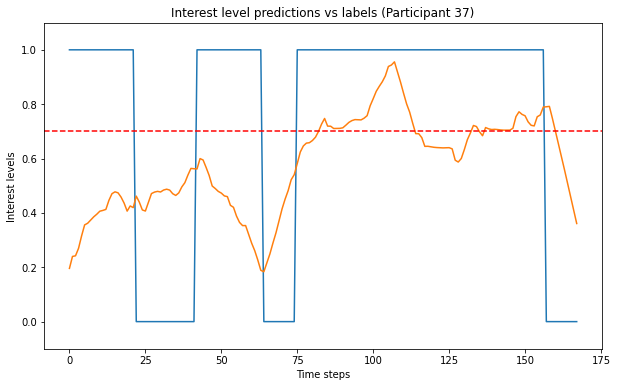

In [18]:
test_indices = [5, 8, 15, 17, 23, 32, 37]
for ind in test_indices:
    temptest = f"finaldata_{250}/{ind}.csv"

    chunked_df = preprocess_and_chunk(temptest, chunk_size)
    otherDF = chunked_df.copy(deep=True)
    otherDF = otherDF.drop(columns=['Label', 'Frame'])
    otherDF = otherDF.fillna(otherDF.median())

    y_pred_proba = svm_clf.predict_proba(otherDF)
    y_pred = svm_clf.predict(otherDF)
    realLabels = chunked_df['Label'].tolist()

    print(f"{ind}\n{classification_report(realLabels, y_pred)}")

    # for x,y in zip(y_pred_proba, y_pred):
    #     print(round(x[1],2),y)

    temp = []
    for x in y_pred_proba:
        temp.append(x[1])
    temp = smooth_data(temp, 20)

    import matplotlib.pyplot as plt

    plt.figure(figsize=(10,6))
    plt.plot(chunked_df.index, chunked_df['Label'])
    plt.plot(range(len(temp)), temp, label='temp')
    plt.axhline(0.7, color='r', linestyle='--', label='Threshold')


    plt.xlabel('Time steps')
    plt.ylabel('Interest levels')
    plt.title(f'Interest level predictions vs labels (Participant {ind})')
    plt.ylim([-0.1, 1.1])  # this ensures that the y-axis is scaled appropriately for binary data
    plt.show()

XGB PREDICTIONS:
              precision    recall  f1-score   support

           0       0.51      0.55      0.53        33
           1       0.88      0.87      0.88       132

    accuracy                           0.81       165
   macro avg       0.70      0.71      0.70       165
weighted avg       0.81      0.81      0.81       165

SVM PREDICTIONS:
              precision    recall  f1-score   support

           0       0.42      0.85      0.57        33
           1       0.95      0.71      0.81       132

    accuracy                           0.74       165
   macro avg       0.69      0.78      0.69       165
weighted avg       0.84      0.74      0.76       165

MAJORITY PREDICTIONS:
              precision    recall  f1-score   support

           0       0.33      0.67      0.44        33
           1       0.89      0.67      0.76       132

    accuracy                           0.67       165
   macro avg       0.61      0.67      0.60       165
weighted avg      

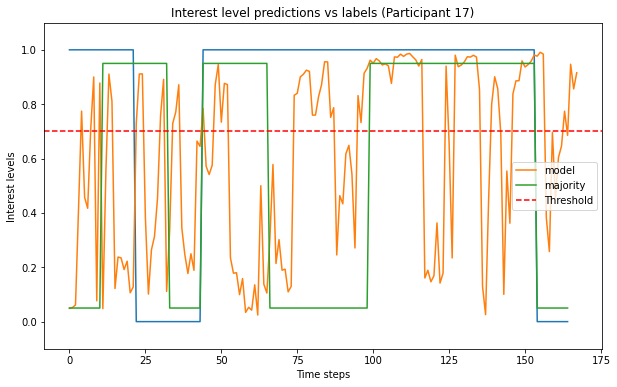

XGB PREDICTIONS:
              precision    recall  f1-score   support

           0       0.46      0.82      0.59        22
           1       0.98      0.88      0.93       182

    accuracy                           0.88       204
   macro avg       0.72      0.85      0.76       204
weighted avg       0.92      0.88      0.89       204

SVM PREDICTIONS:
              precision    recall  f1-score   support

           0       0.34      0.77      0.47        22
           1       0.97      0.82      0.89       182

    accuracy                           0.81       204
   macro avg       0.65      0.80      0.68       204
weighted avg       0.90      0.81      0.84       204

MAJORITY PREDICTIONS:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.89      0.95      0.91       182

    accuracy                           0.84       204
   macro avg       0.44      0.47      0.46       204
weighted avg      

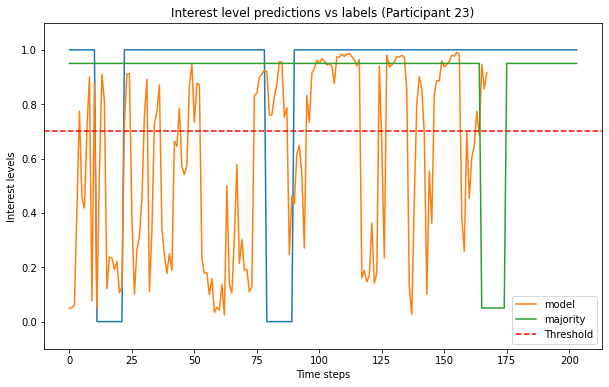

XGB PREDICTIONS:
              precision    recall  f1-score   support

           0       0.07      0.09      0.08        23
           1       0.88      0.85      0.86       175

    accuracy                           0.76       198
   macro avg       0.47      0.47      0.47       198
weighted avg       0.78      0.76      0.77       198

SVM PREDICTIONS:
              precision    recall  f1-score   support

           0       0.36      0.52      0.43        23
           1       0.93      0.88      0.91       175

    accuracy                           0.84       198
   macro avg       0.65      0.70      0.67       198
weighted avg       0.87      0.84      0.85       198

MAJORITY PREDICTIONS:
              precision    recall  f1-score   support

           0       0.42      0.35      0.38        23
           1       0.92      0.94      0.93       175

    accuracy                           0.87       198
   macro avg       0.67      0.64      0.65       198
weighted avg      

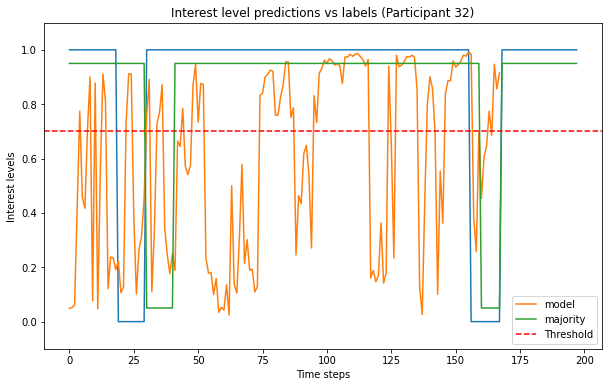

0.7713150857322637 0.6781500707881076
--------------------------- FINAL SCORE ---------------------------
XGB PREDICTIONS:
              precision    recall  f1-score   support

           0       0.37      0.49      0.42        78
           1       0.91      0.87      0.89       489

    accuracy                           0.82       567
   macro avg       0.64      0.68      0.66       567
weighted avg       0.84      0.82      0.83       567

SVM PREDICTIONS:
              precision    recall  f1-score   support

           0       0.38      0.73      0.50        78
           1       0.95      0.81      0.88       489

    accuracy                           0.80       567
   macro avg       0.67      0.77      0.69       567
weighted avg       0.87      0.80      0.82       567

LIRIDON PREDICTIONS:
              precision    recall  f1-score   support

           0       0.48      0.38      0.43        78
           1       0.90      0.93      0.92       489

    accuracy         

In [19]:
test_indices = [17, 23, 32]
y_pred_agg_svm = []
y_score_svm_agg = []
y_pred_agg_xgb = []
y_score_xgb_agg = []
realLabels_agg = []
liridon_agg = []
elena_agg = []
sunny_agg = []
majority_agg = []
for ind in test_indices:
    temptest = f"human_labels/{ind}.csv"
    
    chunked_df = preprocess_and_chunk(temptest, chunk_size, humanCheck=True)
    otherDF = chunked_df.copy(deep=True)
    liridonLabels = otherDF['liridonLabels'].tolist()
    liridon_agg += liridonLabels
    elenaLabels = otherDF['elenaLabels'].tolist()
    elena_agg += elenaLabels
    sunnyLabels = otherDF['sunnyLabels'].tolist()
    sunny_agg += sunnyLabels

    majorityLabels = [1 if x+y+z >= 2 else 0 for x, y, z in zip(liridonLabels, sunnyLabels, elenaLabels)]
    majority_agg += majorityLabels

    liridonGraph = [0.02 if x == 0 else 0.98 for x in liridonLabels]
    elenaGraph = [0.04 if x == 0 else 0.96 for x in elenaLabels]
    sunnyGraph = [0.06 if x == 0 else 0.94 for x in sunnyLabels]
    majorityGraph = [ 0.05 if x == 0 else 0.95 for x in majorityLabels]

    otherDF = otherDF.drop(columns=['Label', 'Frame', 'liridonLabels', 'elenaLabels', 'sunnyLabels'])
    otherDF = otherDF.fillna(otherDF.median())

    y_score_svm = svm_clf.predict_proba(otherDF)[:, 1] 
    y_pred_svm = svm_clf.predict(otherDF)
    y_pred_agg_svm += y_pred_svm.tolist()
    y_score_svm_agg += y_pred_svm.tolist()
    
    y_score_xgb = model.predict_proba(otherDF)[:, 1] 
    y_pred_xgb = model.predict(otherDF)
    y_pred_agg_xgb += y_pred_xgb.tolist()    
    y_score_xgb_agg += y_pred_xgb.tolist()
    
    realLabels = chunked_df['Label'].tolist()
    realLabels_agg += realLabels

    print(f"XGB PREDICTIONS:\n{classification_report(realLabels, y_pred_xgb)}")
    print(f"SVM PREDICTIONS:\n{classification_report(realLabels, y_pred_svm)}")
    # print(f"LIRIDON PREDICTIONS:\n{classification_report(realLabels, liridonLabels)}")
    # print(f"ELENA PREDICTIONS:\n{classification_report(realLabels, elenaLabels)}")
    # print(f"SUNNY PREDICTIONS:\n{classification_report(realLabels, sunnyLabels)}")
    print(f"MAJORITY PREDICTIONS:\n{classification_report(realLabels, majorityLabels)}")

    # for x,y in zip(y_pred_proba, y_pred):
    #     print(round(x[1],2),y)

    temp = []
    for x in y_pred_proba:
        temp.append(x[1])
    temp = smooth_data(temp, 1)

    import matplotlib.pyplot as plt

    plt.figure(figsize=(10,6))
    plt.plot(chunked_df.index, chunked_df['Label'])
    plt.plot(range(len(temp)), temp, label='model')
    # plt.plot(range(len(liridonGraph)), liridonGraph, label='liridon')
    # plt.plot(range(len(elenaGraph)), elenaGraph, label='elena')
    # plt.plot(range(len(sunnyGraph)), sunnyGraph, label='sunny')
    plt.plot(range(len(majorityGraph)), majorityGraph, label='majority')
    plt.axhline(0.7, color='r', linestyle='--', label='Threshold')


    plt.xlabel('Time steps')
    plt.ylabel('Interest levels')
    plt.title(f'Interest level predictions vs labels (Participant {ind})')
    plt.ylim([-0.1, 1.1])  # this ensures that the y-axis is scaled appropriately for binary data
    plt.legend()
    plt.show()


# Compute ROC curve and ROC area for SVM
fpr_svm, tpr_svm, _ = roc_curve(realLabels_agg, y_score_svm_agg)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Compute ROC curve and ROC area for XGB
fpr_xgb, tpr_xgb, _ = roc_curve(realLabels_agg, y_score_xgb_agg)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

print(roc_auc_svm, roc_auc_xgb)

print('--------------------------- FINAL SCORE ---------------------------')
print(f"XGB PREDICTIONS:\n{classification_report(realLabels_agg, y_pred_agg_xgb)}")
print(f"SVM PREDICTIONS:\n{classification_report(realLabels_agg, y_pred_agg_svm)}")
print(f"LIRIDON PREDICTIONS:\n{classification_report(realLabels_agg, liridon_agg)}")
print(f'AUROC LIRIDON:{roc_auc_score(realLabels_agg, liridon_agg)}')
print(f"ELENA PREDICTIONS:\n{classification_report(realLabels_agg, elena_agg)}")
print(f'AUROC ELENA:{roc_auc_score(realLabels_agg, elena_agg)}')
print(f"SUNNY PREDICTIONS:\n{classification_report(realLabels_agg, sunny_agg)}")
print(f'AUROC SUNNY:{roc_auc_score(realLabels_agg, sunny_agg)}')
print(f"MAJORITY PREDICTIONS:\n{classification_report(realLabels_agg, majority_agg)}")
print(f'AUROC MAJORITY:{roc_auc_score(realLabels_agg, majority_agg)}')



In [20]:
from sklearn.dummy import DummyClassifier

def dummyClassifierResults(classifier, X_train_filled, y_train, X_test, y_test):
    predictor = DummyClassifier(strategy=classifier ,random_state=42, constant=0)        
    predictor.fit(X_train_filled, y_train)
    y_pred = predictor.predict(X_test)
    
    report = classification_report(y_test, y_pred, output_dict=True)
    auroc = roc_auc_score(y_test, predictor.predict_proba(X_test)[:, 1])
    return report, auroc

# ['prior', 'stratified', 'uniform', 'constant', 'most_frequent']

types = ['most_frequent', 'prior', 'uniform', 'stratified', 'constant']
all_reports = []

for t in types:
    report, auroc = dummyClassifierResults(t, X_train_filled, y_train, X_test_filled, y_test)
    for label, metrics in report.items():
        if label in ['0', '1', 'macro avg', 'weighted avg']:
            metrics['auroc'] = auroc if label in ['macro avg', 'weighted avg'] else None
            metrics['classifier'] = t
            metrics['class'] = label
            all_reports.append(metrics)

df = pd.DataFrame(all_reports)
df = df[['classifier', 'class', 'precision', 'recall', 'f1-score', 'auroc']] # specify the order of columns
df.to_excel('classification_reports.xlsx', index=False)

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted s

In [21]:
# accuracy_with_features_svm = classification_report(y_test, y_emo_svm, output_dict=True)
# with_svm_auroc = roc_auc_score(y_test, y_emo_svm)
# conf_with_svm = confusion_matrix(y_test,y_emo_svm)

# accuracy_without_features_svm = classification_report(y_test, y_no_emo_svm, output_dict=True)
# without_svm_auroc = roc_auc_score(y_test, y_no_emo_svm)
# conf_without_svm = confusion_matrix(y_test,y_no_emo_svm)

# accuracy_with_features_xgb = classification_report(y_test, y_emo_xgb, output_dict=True)
# with_xgb_auroc = roc_auc_score(y_test, y_emo_xgb)
# conf_with_xgb = confusion_matrix(y_test,y_emo_xgb)

# accuracy_without_features_xgb = classification_report(y_test, y_no_emo_xgb, output_dict=True)
# without_xgb_auroc = roc_auc_score(y_test, y_no_emo_xgb)
# conf_without_xgb = confusion_matrix(y_test,y_no_emo_xgb)



# print(accuracy_without_features_xgb)
# # print(f'{accuracy_with_features}')
# # print(conf_with)
# # print('-----------------------------------------------------------------')
# # print(f'{accuracy_without_features}')
# # print(conf_without)


# tempReport = []
# for label, metrics in accuracy_with_features_svm.items():
#     print(label, metrics)
#     if label in ['0', '1', 'macro avg', 'weighted avg']:
#         metrics['auroc'] = with_svm_auroc if label == '0' else None
#         metrics['classifier'] = 'SVM_EMO'
#         metrics['class'] = label
#         tempReport.append(metrics)
        
# for label, metrics in accuracy_without_features_svm.items():
#     if label in ['0', '1', 'macro avg', 'weighted avg']:
#         metrics['auroc'] = without_svm_auroc if label == '0' else None
#         metrics['classifier'] = 'SVM_NO_EMO'
#         metrics['class'] = label
#         tempReport.append(metrics)
        
# for label, metrics in accuracy_with_features_xgb.items():
#     if label in ['0', '1', 'macro avg', 'weighted avg']:
#         metrics['auroc'] = with_xgb_auroc if label == '0' else None
#         metrics['classifier'] = 'XGB_EMO'
#         metrics['class'] = label
#         tempReport.append(metrics)     
        
# for label, metrics in accuracy_without_features_xgb.items():
#     if label in ['0', '1', 'macro avg', 'weighted avg']:
#         metrics['auroc'] = without_xgb_auroc if label == '0' else None
#         metrics['classifier'] = 'XGB_NO_EMO'
#         metrics['class'] = label
#         tempReport.append(metrics)    
               
# df = pd.DataFrame(tempReport)
# df = df[['classifier', 'class', 'precision', 'recall', 'f1-score', 'auroc']] # specify the order of columns
# df.to_excel('classification_reports_with_without.xlsx', index=False)


Pearsons correlation coefficient: 0.009


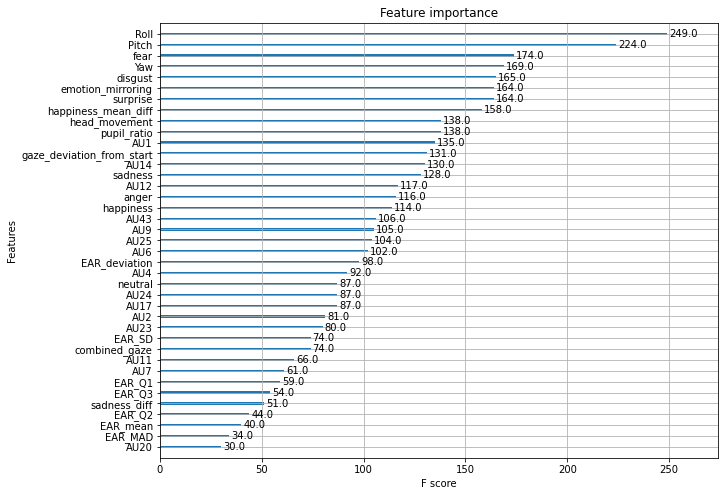

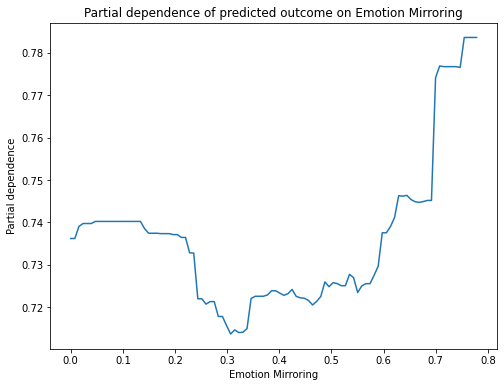

In [22]:
from scipy.stats import pearsonr
import xgboost
# Assuming y_train is a numpy array and 'emotion_mirroring' is a column in X_train_filled
emotion_mirroring = X_train_filled['emotion_mirroring']
correlation_coeff, _ = pearsonr(emotion_mirroring, y_train)

print('Pearsons correlation coefficient: %.3f' % correlation_coeff)

fig, ax = plt.subplots(figsize=(10, 8))  # Adjust the size as needed.
xgboost.plot_importance(model, ax=ax)
plt.show()

from sklearn.inspection import partial_dependence

features = ['emotion_mirroring']
pdp_result = partial_dependence(model, X_train_filled, features)

pdp = pdp_result['average'][0]
feature_values = pdp_result['values'][0]

# Creating a plot
plt.figure(figsize=(8, 6))
plt.plot(feature_values, pdp)
plt.xlabel('Emotion Mirroring')
plt.ylabel('Partial dependence')
plt.title('Partial dependence of predicted outcome on Emotion Mirroring')
plt.show()